# Multi-task face recognition model
"Training a multi-task learning model that can simultaneously perform face recognition, age estimation, and gender classification"   
**Face recognition**:
* A Siamese Network with three identical subnetworks is used to compare the similarity of images using a triplet loss function.   
* The backbone CNN is InceptionV3 to output image features.   
* Features are then flattened and passed through few dense layers to output image embeddings.

**Age and gender detection**:
* Image embeddings are passed through two different feed forward heads with a sigmoid function as the activation function for the last layer.

## Setup

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random
from pathlib import Path
import tensorflow as tf
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import InceptionV3


target_shape = (75, 75)


## Load the dataset


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Preprocessed dataset saved in drive to read directly

# anchor_path = '/content/drive/MyDrive/celebA Dataset/Matching_triplets/anchor_image.npy'
# pos_path = '/content/drive/MyDrive/celebA Dataset/Matching_triplets/pos_image.npy'
# neg_path = '/content/drive/MyDrive/celebA Dataset/Matching_triplets/neg_image.npy'
# gender_path = '/content/drive/MyDrive/celebA Dataset/Matching_triplets/anchor_gender.npy'
# age_path = '/content/drive/MyDrive/celebA Dataset/Matching_triplets/anchor_age.npy'

anchor_path = '/content/drive/MyDrive/Depi/Project/Model_training/celebA Dataset/Matching_triplets/anchor_image.npy'
pos_path = '/content/drive/MyDrive/Depi/Project/Model_training/celebA Dataset/Matching_triplets/pos_image.npy'
neg_path = '/content/drive/MyDrive/Depi/Project/Model_training/celebA Dataset/Matching_triplets/neg_image.npy'
gender_path = '/content/drive/MyDrive/Depi/Project/Model_training/celebA Dataset/Matching_triplets/anchor_gender.npy'
age_path = '/content/drive/MyDrive/Depi/Project/Model_training/celebA Dataset/Matching_triplets/anchor_age.npy'

## Preparing the data


In [4]:

def preprocess_image(image):
    """
    Preprocess the input image by resizing it to the target shape.
    """
    image = tf.image.resize(image, target_shape)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Ensure float32
    return image


In [5]:

def triplet_generator(batch_size, mode='train', split_ratio=0.8):
    """
    Generator function to yield batches of triplets for training or testing.
    """
    # Load the full datasets using memory mapping
    num_used_samples = 6000
    anchor_images = np.load(anchor_path, mmap_mode='r')[:num_used_samples]
    positive_images = np.load(pos_path, mmap_mode='r')[:num_used_samples]
    negative_images = np.load(neg_path, mmap_mode='r')[:num_used_samples]
    anchor_gender = np.load(gender_path, mmap_mode='r')[:num_used_samples]
    anchor_age = np.load(age_path, mmap_mode='r')[:num_used_samples]

    total_images = len(anchor_images)
    train_size = int(total_images * split_ratio)

    total_batches = total_images // batch_size

    if mode == 'train':
        indices = np.arange(train_size)
    elif mode == 'test':
        indices = np.arange(train_size, total_images)
    else:
        raise ValueError("mode must be 'train' or 'test'")

    i = 0
    while i < total_batches:  # Loop on all dataset to generate batches
        batch_indices = np.random.choice(indices, batch_size)
        anchor_batch = np.array([preprocess_image(anchor_images[i]) for i in batch_indices])
        pos_batch = np.array([preprocess_image(positive_images[i]) for i in batch_indices])
        neg_batch = np.array([preprocess_image(negative_images[i]) for i in batch_indices])
        gender_batch = np.array([anchor_gender[i] for i in batch_indices])
        age_batch = np.array([anchor_age[i] for i in batch_indices])
        i += 1
        yield anchor_batch, pos_batch, neg_batch, gender_batch, age_batch



# Define batch size
BATCH_SIZE = 256

# Create datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(BATCH_SIZE, mode='train'),
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, ), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, ), dtype=tf.float32),
    )
)
val_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(BATCH_SIZE, mode='test'),
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, ), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, ), dtype=tf.float32),
    )
)

# Prefetch datasets for efficiency
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

### Visualizing triplets samples

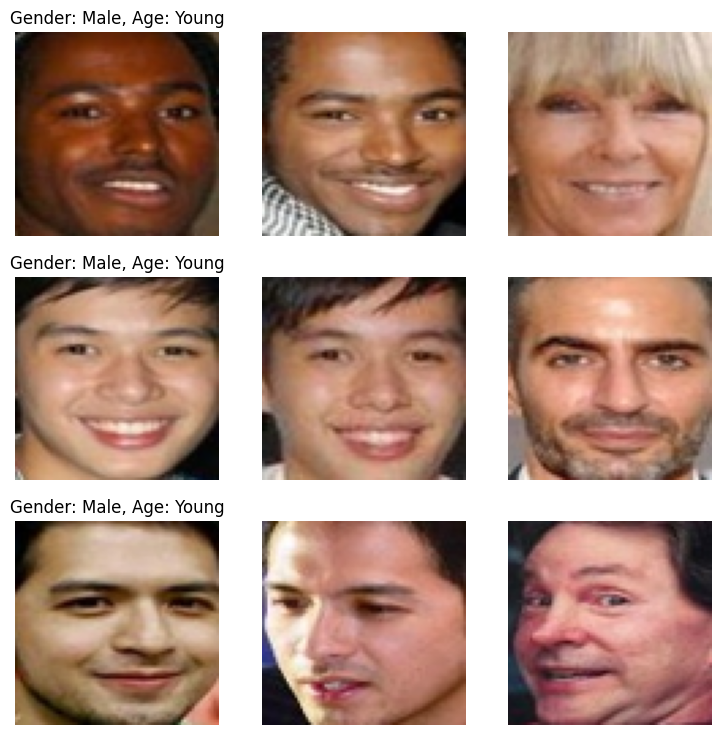

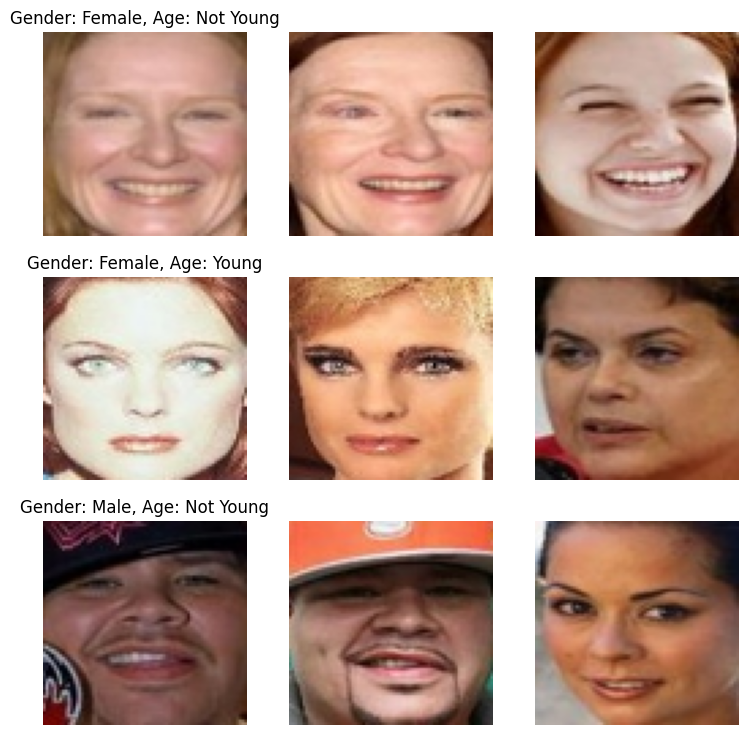

In [6]:

def visualize(anchor, positive, negative, gender, age):
    """Visualize a few triplets from the supplied batches."""
    def show(ax, image):
        ax.imshow(image)
        ax.axis('off')

    fig = plt.figure(figsize=(9, 9))
    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        axs[i, 0].set_title(f"Gender: {'Male' if gender[i] == 1 else 'Female'}, Age: {'Young' if age[i] == 1 else 'Not Young'}")
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

# Get one batch of triplets to visualize from the training set
for anchor_batch, pos_batch, neg_batch, gender_batch, age_batch in train_dataset.take(1):
    visualize(anchor_batch.numpy(), pos_batch.numpy(), neg_batch.numpy(), gender_batch.numpy(), age_batch.numpy())

# Get one batch of triplets to visualize from the testing set
for anchor_batch, pos_batch, neg_batch, gender_batch, age_batch in val_dataset.take(1):
    visualize(anchor_batch.numpy(), pos_batch.numpy(), neg_batch.numpy(), gender_batch.numpy(), age_batch.numpy())


## Model Architecture
### Feature Extraction Backbone 'base_cnn'
 we will use an InceptionV3 model pretrained on ImageNet and connect a few Dense layers to generate image embeddings.   
 We will freeze the weights of all the layers of the model up until the layer `conv2d_85` and leave the bottom few layers trainable, so that we can fine-tune their weights during training.   

### Face recognition head
The base_cnn will receive three images, where
two of them will be similar (_anchor_ and _positive_ samples), and the third will be unrelated (a _negative_ example.)

The base_cnn will generate the embeddings. Embeddings are then passed to the recognition head and then to the distance layer which outputs the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.
The goal for this head is to learn to estimate the similarity between images.

For this task, we use a triplet loss function:   
`L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)`

### Age detection head
The age detection head receives the features of the anchor image outputted from the recognition head. These features are passed through a feed forward network with a final head having a sigmoid acivation function.   
The output of the head is either _0_ for _old_ or _1_ for _young_.   

### Gender detection head
The gender detection head receives the features of the anchor image outputted from the recognition head. These features are passed through a feed forward network with a final head having a sigmoid acivation function.   
The output of the head is either _0_ for _femalr_ or _1_ for _male_.

For age and gender heads, we use `Binary Cross Entropy` loss.



In [ ]:

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)     # distance between anchor and posititve images
        an_distance = ops.sum(tf.square(anchor - negative), -1)     # distance between anchor and negaitve images
        return (ap_distance, an_distance)


In [ ]:
# Complete model architecture

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

inception_base = InceptionV3(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
flatten_features = layers.Flatten()(inception_base.output)

# Base feature vector extractor model
base_cnn =  Model(inception_base.input, flatten_features, name="base_cnn")

# Face recognition head
rec_dense1 = layers.Dense(512, activation="relu")(base_cnn.output)
rec_dense1 = layers.BatchNormalization()(rec_dense1)
rec_dense2 = layers.Dense(256, activation="relu")(rec_dense1)
rec_dense2 = layers.BatchNormalization()(rec_dense2)
rec_output = layers.Dense(256)(rec_dense2)

rec_head = Model(base_cnn.output, rec_output, name="rec_head")

rec_anchor_output = rec_head(base_cnn(applications.inception_v3.preprocess_input(anchor_input)))
rec_pos_output = rec_head(base_cnn(applications.inception_v3.preprocess_input(positive_input)))
rec_neg_output = rec_head(base_cnn(applications.inception_v3.preprocess_input(negative_input)))

distances_rec_output = DistanceLayer()(
    rec_anchor_output,
    rec_pos_output,
    rec_neg_output,
)

# Gender classification head
gender_dense1 = layers.Dense(256, activation="relu")(rec_anchor_output)
gender_dense1 = layers.BatchNormalization()(gender_dense1)
gender_dense2 = layers.Dense(128, activation="relu")(rec_anchor_output)
gender_dense2 = layers.BatchNormalization()(gender_dense2)
gender_output = layers.Dense(1, activation='sigmoid')(gender_dense2)

gender_head = Model(rec_anchor_output, gender_output, name="gender_head")
gender_output = gender_head(rec_anchor_output)

# Age classification head
age_dense1 = layers.Dense(256, activation="relu")(rec_anchor_output)
age_dense1 = layers.BatchNormalization()(age_dense1)
age_dense2 = layers.Dense(128, activation="relu")(rec_anchor_output)
age_dense2 = layers.BatchNormalization()(age_dense2)
age_output = layers.Dense(1, activation='sigmoid')(age_dense2)

age_head = Model(rec_anchor_output, age_output, name="age_head")
age_output = age_head(rec_anchor_output)

face_analysis_model = Model(inputs=[anchor_input, positive_input, negative_input],
                            outputs=[distances_rec_output, gender_output, age_output], name="face_analysis")


In [ ]:
# Freeze backbone layers except for the last few layers

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv2d_85":
        trainable = True
    layer.trainable = trainable

### Review complete model architecture and trainable parameters after freezing layers

In [ ]:
face_analysis_model.summary()

Model: "face_analysis"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer)       │ (None, 75, 75, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positive (InputLayer)     │ (None, 75, 75, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ negative (InputLayer)     │ (None, 75, 75, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ true_divide_6             │ (None, 75, 75, 3)      │              0 │ anchor[0][0]           │
│ (TrueDivide)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ true_divide_7             │ (None, 75, 75, 3)      │              0 │ positive[0][0]         │
│ (TrueDivide)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ true_divide_8             │ (None, 75, 75, 3)      │              0 │ negative[0][0]         │
│ (TrueDivide)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_6 (Subtract)     │ (None, 75, 75, 3)      │              0 │ true_divide_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_7 (Subtract)     │ (None, 75, 75, 3)      │              0 │ true_divide_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_8 (Subtract)     │ (None, 75, 75, 3)      │              0 │ true_divide_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ base_cnn (Functional)     │ (None, 2048)           │     21,802,784 │ subtract_6[0][0],      │
│                           │                        │                │ subtract_7[0][0],      │
│                           │                        │                │ subtract_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rec_head (Functional)     │ (None, 256)            │      1,249,280 │ base_cnn[0][0],        │
│                           │                        │                │ base_cnn[1][0],        │
│                           │                        │                │ base_cnn[2][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distance_layer_2          │ [(None), (None)]       │              0 │ rec_head[0][0],        │
│ (DistanceLayer)           │                        │                │ rec_head[1][0],        │
│                           │                        │                │ rec_head[2][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_head (Functional)  │ (None, 1)              │         33,537 │ rec_head[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_head (Functional)     │ (None, 1)              │         33,537 │ rec_head[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,119,138 (88.19 MB)

 Trainable params: 1,314,306 (5.01 MB)

 Non-trainable params: 21,804,832 (83.18 MB)

## Complete Model Training process


In [ ]:
EPOCHS = 2
LEARNING_RATE = 0.0001

# Loss function (for age and gender)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Optimizer
optimizer=optimizers.Adam(LEARNING_RATE)

# Metrics
train_age_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_age_acc_metric = tf.keras.metrics.BinaryAccuracy()
train_gender_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_gender_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Depi/Project/Model_training/training_data/training_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 face_analysis_model=face_analysis_model)

In [ ]:
def update_losses_dict(age_loss, gender_loss, rec_loss, total_loss, loss_dict):
  loss_dict['gender'].append(gender_loss)
  loss_dict['age'].append(age_loss)
  loss_dict['rec'].append(rec_loss)
  loss_dict['total'].append(total_loss)

  return loss_dict

In [ ]:
# Training step function
@tf.function
def train_step(dataset):
    margin = 0.5
    num_of_batches = 19

    epoch_loss_dict = {'gender': [],
                      'age': [],
                      'rec': [],
                      'total': []}

    dataset_iter = iter(dataset)
    for batch in range(num_of_batches):
      anchor_batch, pos_batch, neg_batch, gender_batch, age_batch = next(dataset_iter)     # Loop over batches

      with tf.GradientTape() as tape:
        rec_output, gender_output, age_output = face_analysis_model([anchor_batch, pos_batch, neg_batch])
        ap_distance, an_distance = rec_output

        # losses
        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        rec_diff = ap_distance - an_distance
        rec_loss = ops.sum(tf.maximum(rec_diff + margin, 0.0))/BATCH_SIZE

        # Add gender loss & age loss (BinaryCrossentropy)
        gender_loss = cross_entropy(gender_batch, gender_output)
        age_loss = cross_entropy(age_batch, age_output)

        # How to add the three losses?
        batch_loss = (rec_loss + gender_loss + age_loss) / 3

        # Update Losses dict
        epoch_loss_dict = update_losses_dict(age_loss, gender_loss, rec_loss, batch_loss, epoch_loss_dict)

        # Update metrics
        train_age_acc_metric.update_state(age_batch, age_output)
        train_gender_acc_metric.update_state(gender_batch, gender_output)

      gradients = tape.gradient(batch_loss, face_analysis_model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, face_analysis_model.trainable_variables))
      print(f'\rbatch {batch+1}/{num_of_batches}: Losses: age: {age_loss:.2f} | gender: {gender_loss:.2f} | rec: {rec_loss:.2f} | Total: {batch_loss:.2f}', end='')

    return epoch_loss_dict


In [ ]:
def test_step(dataset):
  margin = 0.5
  num_of_batches = 5

  epoch_loss_dict = {'gender': [],
                    'age': [],
                    'rec': [],
                    'total': []}

  dataset_iter = iter(dataset)
  for batch in range(num_of_batches):
    anchor_batch, pos_batch, neg_batch, gender_batch, age_batch = next(dataset_iter)
    rec_output, gender_output, age_output = face_analysis_model([anchor_batch, pos_batch, neg_batch], training=False)
    ap_distance, an_distance = rec_output

    # losses
    # Computing the Triplet Loss by subtracting both distances and
    # making sure we don't get a negative value.
    rec_diff = ap_distance - an_distance
    rec_loss = ops.sum(tf.maximum(rec_diff + margin, 0.0))/BATCH_SIZE

    # Computing gender loss & age loss (BinaryCrossentropy)
    gender_loss = cross_entropy(gender_batch, gender_output)
    age_loss = cross_entropy(age_batch, age_output)

    # Add the three losses
    batch_loss = (rec_loss + gender_loss + age_loss)/3

    # Update Losses dict
    epoch_loss_dict = update_losses_dict(age_loss, gender_loss, rec_loss, batch_loss, epoch_loss_dict)

    # Update metrics
    val_age_acc_metric.update_state(age_batch, age_output)
    val_gender_acc_metric.update_state(gender_batch, gender_output)

    print(f'\rbatch {batch+1}/{num_of_batches}: Losses: age: {age_loss:.2f} | gender: {gender_loss:.2f} | rec: {rec_loss:.2f} | Total: {batch_loss:.2f}', end='')

  return epoch_loss_dict

In [ ]:
def train(train_dataset, val_dataset, epochs):
  total_train_loss = {'gender': [], 'age': [], 'rec': [], 'total': []}
  total_val_loss = {'gender': [], 'age': [], 'rec': [], 'total': []}

  for epoch in range(epochs):
    start = time.time()

    ## TRAINING
    epoch_loss_train = train_step(train_dataset)

    train_age_acc = train_age_acc_metric.result()
    train_gender_acc = train_gender_acc_metric.result()

    gender_epoch_loss = np.mean(epoch_loss_train['gender'])
    age_epoch_loss = np.mean(epoch_loss_train['age'])
    rec_epoch_loss = np.mean(epoch_loss_train['rec'])
    total_epoch_loss = np.mean(epoch_loss_train['total'])

    total_train_loss = update_losses_dict(age_epoch_loss, gender_epoch_loss, rec_epoch_loss, total_epoch_loss, total_train_loss)

    print(f'\nepoch {epoch + 1}: {(time.time()-start):.2f} sec | age_acc: {train_age_acc:.2f} | gender_acc: {train_gender_acc:.2f}')
    print(f'epoch {epoch + 1}: age_loss: {age_epoch_loss:.2f} | gender_loss: {gender_epoch_loss:.2f} | rec_loss: {rec_epoch_loss:.2f} | tot_loss: {total_epoch_loss:.2f}\n')

    train_age_acc_metric.reset_state()
    train_gender_acc_metric.reset_state()

    ## VALIDATION
    epoch_loss_val = test_step(val_dataset)

    val_age_acc = val_age_acc_metric.result()
    val_gender_acc = val_gender_acc_metric.result()

    gender_epoch_loss = np.mean(epoch_loss_val['gender'])
    age_epoch_loss = np.mean(epoch_loss_val['age'])
    rec_epoch_loss = np.mean(epoch_loss_val['rec'])
    total_epoch_loss = np.mean(epoch_loss_val['total'])

    total_val_loss = update_losses_dict(age_epoch_loss, gender_epoch_loss, rec_epoch_loss, total_epoch_loss, total_val_loss)

    print(f'\nepoch val_{epoch + 1}: {(time.time()-start):.2f} sec | age_acc: {val_age_acc:.2f} | gender_acc: {val_gender_acc:.2f}')
    print(f'epoch val_{epoch + 1}: age_loss: {age_epoch_loss:.2f} | gender_loss: {gender_epoch_loss:.2f} | rec_loss: {rec_epoch_loss:.2f} | tot_loss: {total_epoch_loss:.2f}')
    print('----------------------------')

    val_age_acc_metric.reset_state()
    val_gender_acc_metric.reset_state()

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  return total_train_loss, total_val_loss

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
total_train_loss, total_val_loss = train(train_dataset, val_dataset, epochs=10)

19/19: Losses: age: 0.50 | gender: 0.69 | rec: 0.46 | Total: 0.55
epoch 1: 53.24 sec | age_acc: 0.77 | gender_acc: 0.54
epoch 1: age_loss: 0.54 | gender_loss: 0.71 | rec_loss: 0.50 | tot_loss: 0.58
batch 5/5: Losses: age: 0.58 | gender: 0.68 | rec: 0.46 | Total: 0.57
epoch val_1: 73.72 sec | age_acc: 0.77 | gender_acc: 0.61
epoch val_1: age_loss: 0.54 | gender_loss: 0.68 | rec_loss: 0.40 | tot_loss: 0.54


19/19: Losses: age: 0.53 | gender: 0.68 | rec: 0.35 | Total: 0.52
epoch 2: 58.24 sec | age_acc: 0.78 | gender_acc: 0.58
epoch 2: age_loss: 0.52 | gender_loss: 0.68 | rec_loss: 0.42 | tot_loss: 0.54
batch 5/5: Losses: age: 0.62 | gender: 0.68 | rec: 0.39 | Total: 0.56
epoch val_2: 69.56 sec | age_acc: 0.71 | gender_acc: 0.65
epoch val_2: age_loss: 0.60 | gender_loss: 0.68 | rec_loss: 0.39 | tot_loss: 0.56


19/19: Losses: age: 0.55 | gender: 0.67 | rec: 0.40 | Total: 0.54
epoch 3: 81.92 sec | age_acc: 0.76 | gender_acc: 0.56
epoch 3: age_loss: 0.55 | gender_loss: 0.67 | rec_loss: 0.39

## Model Evaluation

### Plot Train and Validation losses


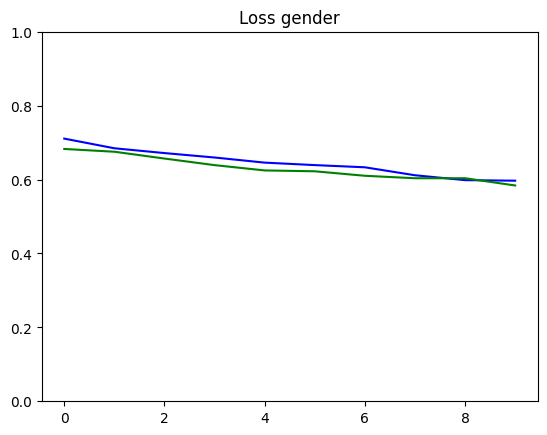

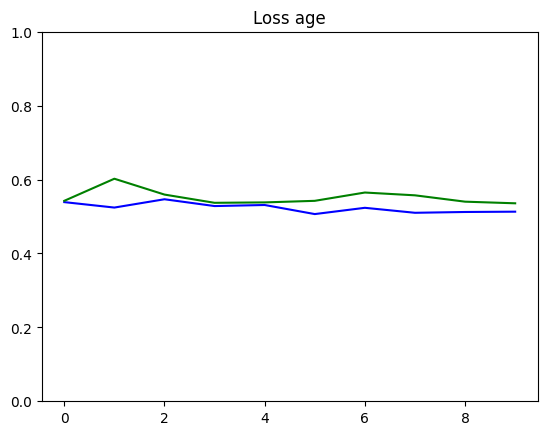

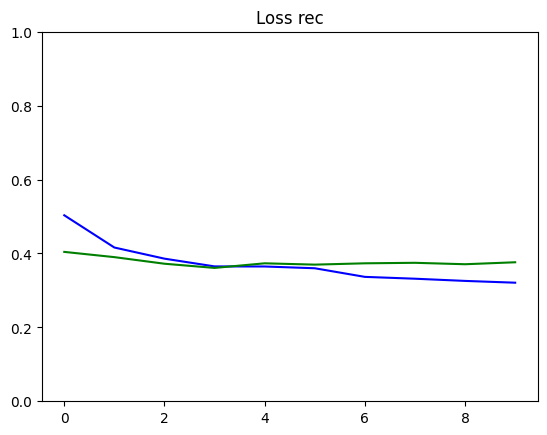

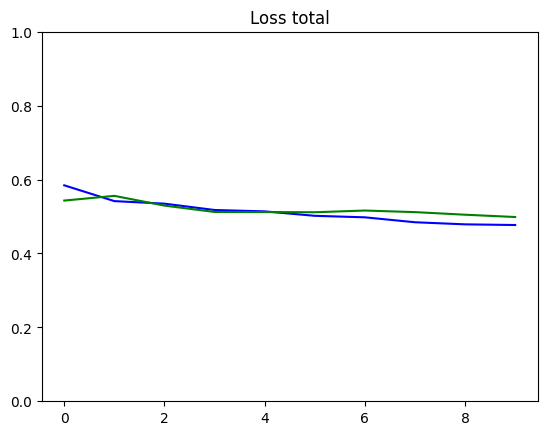

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, ylim=5):
  for key in train_metric.keys():
    plt.figure()
    plt.title(f'{metric_name} {key}')
    plt.ylim(0,ylim)
    plt.plot(train_metric[key],color='blue',label=f'{key}_loss')
    plt.plot(val_metric[key],color='green',label=f'val_{key}_loss')

plot_metrics(total_train_loss, total_val_loss, "Loss", ylim=1.0)